*This Notebook provides a way to get rid of the data batch-effect. As a result of the work, a gene usage tables are formed. The [source code](https://github.com/antigenomics/mirpy) was kindly provided by our supervisors [Mikhail Shugai](https://github.com/mikessh) and [Elizaveta Vlasova](https://github.com/VEK239).*

In [14]:
import sys
import os
import re
import time
import pandas as pd

sys.path.append("../")

from mir.common.parser import *
from mir.common.repertoire import Repertoire
from mir.common.repertoire_dataset import RepertoireDataset
from mir.basic.segment_usage import *
from mir.basic.sampling import RepertoireSampling

# Cohort-I
*fmba, Russia*

## Alpha chain

In [2]:
#metadata
metadata_path = '../../../data/cohort_I/metadata/metadata_fmba_full.txt'
batch_meta_path = '../../../data/cohort_I/metadata/desc_fmba_not_nan_hla.csv'

metadata = pd.read_csv(metadata_path, sep='\t')
metadata.rename(columns={'id': 'file.id_short'}, inplace=True)
metadata['file.id_short'] = metadata['file.id_short'].astype(int)

batch_meta = pd.read_csv(batch_meta_path, sep=',')
batch_meta['file.id_short'] = batch_meta['file.id'].str.split('_').str[0]
batch_meta['file.id_short'] = batch_meta['file.id_short'].astype(int)
batch_meta['run'] = batch_meta['file.id'] + '.clonotypes.TRA.txt'

new_meta = pd.merge(metadata, batch_meta[['file.id_short', 'run', 'folder']], on='file.id_short')
new_meta = new_meta[new_meta['sample.COVID_status'] == 'healthy']
new_meta = new_meta.reset_index(drop=True)
new_meta

,file.id_short,sample.age,sample.sex,sample.height(cm),sample.weight(kg),sample.waist(cm),sample.diastolicBloodPressure(mmHg),sample.bodyTemperature,sample.pulse(beats/min),sample.oxygenLevel(%),...,sample.HLA-DRB1.1,sample.HLA-DRB1.2,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,run,folder
0,20000200808,19,male,187.0,105.0,97.0,80,36.6,74,99.0,...,DRB1*01:01,DRB1*04:04,NaN,NaN,NaN,NaN,NaN,NaN,020000200808_S181_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
1,20000350808,54,female,159.0,86.0,96.0,90,36.3,60,98.0,...,DRB1*07:01,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000350808_S126_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
2,20000360808,30,male,186.0,86.0,89.0,80,36.4,80,97.0,...,DRB1*03:01,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000360808_S102_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
3,20000390808,33,female,157.0,65.0,77.0,60,36.6,72,97.0,...,DRB1*03:01,DRB1*12:02,NaN,NaN,NaN,NaN,NaN,NaN,020000390808_S189_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
4,20000640808,68,female,161.0,103.0,115.0,80,36.6,75,99.0,...,DRB1*01:01,DRB1*15:01,NaN,NaN,NaN,NaN,NaN,NaN,020000640808_S117_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,780003510808,61,male,176.0,85.0,106.0,80,36.4,60,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003510808_S92_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4
233,780003520808,81,male,172.0,74.0,96.0,78,36.5,70,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003520808_S12_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4
234,780003890808,27,female,168.0,61.0,59.0,70,36.5,64,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003890808_S35_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4
235,780003930808,64,male,171.0,60.0,89.0,75,36.6,72,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003930808_S76_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4


In [3]:
base_path = '../../../data/cohort_I/data/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRA',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

3574192
500.78504848480225


In [4]:
dataset.metadata

,file.id_short,sample.age,sample.sex,sample.height(cm),sample.weight(kg),sample.waist(cm),sample.diastolicBloodPressure(mmHg),sample.bodyTemperature,sample.pulse(beats/min),sample.oxygenLevel(%),...,sample.HLA-DRB1.2,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,run,folder,path
0,20000200808,19,male,187.0,105.0,97.0,80,36.6,74,99.0,...,DRB1*04:04,NaN,NaN,NaN,NaN,NaN,NaN,020000200808_S181_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000200808_S181_...
1,20000350808,54,female,159.0,86.0,96.0,90,36.3,60,98.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000350808_S126_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000350808_S126_...
2,20000360808,30,male,186.0,86.0,89.0,80,36.4,80,97.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000360808_S102_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000360808_S102_...
3,20000390808,33,female,157.0,65.0,77.0,60,36.6,72,97.0,...,DRB1*12:02,NaN,NaN,NaN,NaN,NaN,NaN,020000390808_S189_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000390808_S189_...
4,20000640808,68,female,161.0,103.0,115.0,80,36.6,75,99.0,...,DRB1*15:01,NaN,NaN,NaN,NaN,NaN,NaN,020000640808_S117_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000640808_S117_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,780003510808,61,male,176.0,85.0,106.0,80,36.4,60,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003510808_S92_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003510808_S92_L...
233,780003520808,81,male,172.0,74.0,96.0,78,36.5,70,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003520808_S12_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003520808_S12_L...
234,780003890808,27,female,168.0,61.0,59.0,70,36.5,64,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003890808_S35_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003890808_S35_L...
235,780003930808,64,male,171.0,60.0,89.0,75,36.6,72,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003930808_S76_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003930808_S76_L...


In [5]:
dataset.evaluate_segment_usage()

,TRAV35*01,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAV8-6*01,TRAJ27*01,TRAJ19*01,TRAV9-2*01,TRAV1-1*01,...,TRAV17*01,TRAJ6*01,TRAJ21*01,TRAV19*01,TRAV18*01,TRAV12-1*01,TRAV9-1*01,TRAV26-1*01,TRAJ9*01,TRAJ61*01
0,1112,1277,197,27,19,1006,557,0,1664,330,...,1463,624,3,1409,1,1336,17,1559,554,537
1,791,500,282,27,13,833,493,0,1613,342,...,1292,628,2,996,1,1186,7,1250,608,276
2,1152,887,226,25,9,1017,578,0,1682,383,...,1532,821,2,1266,1,1481,15,1271,790,475
3,857,706,203,25,15,701,419,1,1164,356,...,1257,479,1,843,0,950,9,874,447,453
4,72,64,15,4,2,67,40,0,115,34,...,135,36,0,60,0,97,1,107,56,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,97,67,19,4,2,150,93,0,256,81,...,242,118,0,137,0,216,2,161,108,41
233,489,692,113,5,5,613,261,0,990,191,...,941,432,1,521,0,662,0,930,368,165
234,131,118,30,6,2,132,61,0,247,38,...,230,80,0,164,0,177,1,151,80,64
235,261,175,29,1,0,236,142,0,445,86,...,371,186,0,238,0,325,1,439,170,69


In [6]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [7]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')

In [8]:
norm_usage_table_v

     TRAV35*01  TRAV8-6*01  TRAV9-2*01  TRAV1-1*01  TRAV22*01  TRAV36DV7*01  \
0     0.029492    0.026681    0.044132    0.008752   0.020130      0.015515   
1     0.024952    0.026277    0.050882    0.010788   0.016813      0.012713   
2     0.029591    0.026123    0.043205    0.009838   0.019496      0.014513   
3     0.029603    0.024214    0.040207    0.012297   0.020276      0.013264   
4     0.027896    0.025959    0.044556    0.013173   0.019760      0.014336   
..         ...         ...         ...         ...        ...           ...   
232   0.018979    0.029348    0.050088    0.015848   0.016239      0.009783   
233   0.025247    0.031649    0.051113    0.009861   0.017451      0.012597   
234   0.026039    0.026237    0.049096    0.007553   0.016895      0.014311   
235   0.030877    0.027919    0.052644    0.010174   0.024015      0.003076   
236   0.023387    0.020866    0.049817    0.009824   0.018779      0.017649   

     TRAV13-1*01  TRAV6*01  TRAV8-4*01  TRAV21*01  

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [9]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [10]:
sampled_repertoire

Repertoire of 21868 clonotypes and 100000 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAATDSWGKLQF cdr3nt_1
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CASVDAGNMLTF cdr3nt_3
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex                

#### Resampling the repertoire using the new derived usages for V and J genes

In [11]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

6.547260761260986


In [12]:
resampled_repertoire

Repertoire of 36002 clonotypes and 9537751 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAATDSWGKLQF cdr3nt_1
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVSDGWGNTPLVF cdr3nt_10
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex            

#### Resampling all the reperoires from a dataset

In [13]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

3271399
563.537807226181


In [14]:
dataset[14]

Repertoire of 29777 clonotypes and 6356503 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGQRFGGSQGNLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGQTFYNQGGKLIF cdr3nt_1
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CLLGDPGGTSYGKLTF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVSLQGGKLIF cdr3nt_3
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAETPIYNQGGKLIF cdr3nt_4
file.id_short                                                                50001340808
sample.age                                                                            28
sample.sex         

In [15]:
resampled_dataset[14]

Repertoire of 28822 clonotypes and 6356503 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CLLGDPGGTSYGKLTF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVFWGFNKFYF cdr3nt_349
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVNAPSNARLMF cdr3nt_5
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSAS_DKFYF cdr3nt_410
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPYNFNKFYF cdr3nt_700
file.id_short                                                                50001340808
sample.age                                                                            28
sample.sex          

In [16]:
trav_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='V').segment_usage_matrix

In [17]:
traj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='J').segment_usage_matrix

In [18]:
traj_matrix

,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAJ27*01,TRAJ19*01,TRAJ29*01,TRAJ28*01,TRAJ38*01,TRAJ18*01,...,TRAJ14*01,TRAJ40*01,TRAJ15*01,TRAJ41*01,TRAJ13*01,TRAJ57*01,TRAJ6*01,TRAJ21*01,TRAJ9*01,TRAJ61*01
0,0.033915,0.005055,0.000750,0.000389,0.015110,0.000000,0.024582,0.024804,0.010638,0.009111,...,0.000028,0.031332,0.018110,0.016971,0.017055,0.021693,0.016777,0.0,0.015249,0.014221
1,0.016807,0.008690,0.000808,0.000337,0.015999,0.000000,0.028461,0.023206,0.009296,0.009700,...,0.000168,0.027854,0.016908,0.013675,0.019434,0.022465,0.019906,0.0,0.019299,0.008454
2,0.023339,0.005713,0.000647,0.000189,0.015254,0.000000,0.030831,0.023500,0.007681,0.009756,...,0.000027,0.030534,0.017652,0.016817,0.018730,0.009405,0.021344,0.0,0.020428,0.012181
3,0.025046,0.006808,0.000896,0.000466,0.014798,0.000036,0.026766,0.026479,0.011036,0.008922,...,0.000036,0.029811,0.015945,0.016733,0.018095,0.013042,0.016769,0.0,0.015766,0.015551
4,0.025530,0.005193,0.001731,0.000865,0.015578,0.000000,0.026828,0.023367,0.007356,0.007356,...,0.000000,0.020770,0.023367,0.014712,0.025963,0.000865,0.015145,0.0,0.020770,0.005193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.012786,0.003773,0.000838,0.000419,0.019074,0.000000,0.033117,0.024942,0.005869,0.011318,...,0.000000,0.022427,0.019493,0.015720,0.021798,0.006078,0.024104,0.0,0.021798,0.008384
233,0.036421,0.005876,0.000212,0.000159,0.013393,0.000000,0.025040,0.021440,0.009317,0.009052,...,0.000053,0.034569,0.017046,0.018317,0.020487,0.015352,0.022340,0.0,0.019111,0.008576
234,0.023800,0.005647,0.001210,0.000403,0.012303,0.000000,0.026624,0.021178,0.012505,0.010085,...,0.000202,0.032271,0.019968,0.015329,0.017346,0.023598,0.016136,0.0,0.016136,0.012707
235,0.021071,0.003512,0.000125,0.000000,0.016681,0.000000,0.025712,0.028722,0.003386,0.010410,...,0.000000,0.021824,0.021197,0.015552,0.019691,0.006522,0.022451,0.0,0.019691,0.008153


In [19]:
trav_matrix.to_csv('../../../data/cohort_I/data_corrected/v_clonotypes_TRA.csv', index = False)
traj_matrix.to_csv('../../../data/cohort_I/data_corrected/j_clonotypes_TRA.csv', index = False)

### Nonfunctional sequences

In [21]:
base_path = '../../../data/cohort_I/nonfunctional/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRA',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

0
285.883665561676


In [22]:
dataset.metadata

,file.id_short,sample.age,sample.sex,sample.height(cm),sample.weight(kg),sample.waist(cm),sample.diastolicBloodPressure(mmHg),sample.bodyTemperature,sample.pulse(beats/min),sample.oxygenLevel(%),...,sample.HLA-DRB1.2,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,run,folder,path
0,20000200808,19,male,187.0,105.0,97.0,80,36.6,74,99.0,...,DRB1*04:04,NaN,NaN,NaN,NaN,NaN,NaN,020000200808_S181_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000200...
1,20000350808,54,female,159.0,86.0,96.0,90,36.3,60,98.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000350808_S126_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000350...
2,20000360808,30,male,186.0,86.0,89.0,80,36.4,80,97.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000360808_S102_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000360...
3,20000390808,33,female,157.0,65.0,77.0,60,36.6,72,97.0,...,DRB1*12:02,NaN,NaN,NaN,NaN,NaN,NaN,020000390808_S189_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000390...
4,20000640808,68,female,161.0,103.0,115.0,80,36.6,75,99.0,...,DRB1*15:01,NaN,NaN,NaN,NaN,NaN,NaN,020000640808_S117_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000640...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,780003510808,61,male,176.0,85.0,106.0,80,36.4,60,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003510808_S92_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003510...
233,780003520808,81,male,172.0,74.0,96.0,78,36.5,70,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003520808_S12_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003520...
234,780003890808,27,female,168.0,61.0,59.0,70,36.5,64,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003890808_S35_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003890...
235,780003930808,64,male,171.0,60.0,89.0,75,36.6,72,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003930808_S76_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003930...


In [23]:
dataset.evaluate_segment_usage()

,TRAV35*01,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAV8-6*01,TRAJ27*01,TRAJ19*01,TRAV9-2*01,TRAV1-1*01,...,TRAV17*01,TRAJ6*01,TRAJ21*01,TRAV19*01,TRAV18*01,TRAV12-1*01,TRAV9-1*01,TRAV26-1*01,TRAJ9*01,TRAJ61*01
0,634,615,61,12,12,377,269,0,663,178,...,785,278,1,634,0,646,8,632,187,369
1,361,216,103,9,5,278,213,0,479,169,...,537,233,0,546,0,537,4,498,166,180
2,605,470,82,8,4,382,279,0,671,227,...,835,350,1,646,1,685,10,633,268,306
3,466,382,89,7,7,303,213,1,499,162,...,626,212,1,495,0,498,7,462,157,291
4,32,24,4,0,0,20,13,0,35,21,...,55,16,0,16,0,43,1,44,15,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,52,28,8,1,1,34,40,0,91,35,...,106,54,0,74,0,77,2,71,37,24
233,270,294,39,1,2,177,106,0,321,80,...,356,183,0,231,0,269,0,353,96,109
234,64,61,12,3,2,49,29,0,96,16,...,99,34,0,81,0,78,1,78,20,38
235,114,71,6,0,0,65,53,0,157,25,...,148,89,0,108,0,119,1,155,45,56


In [24]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [25]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')

In [26]:
norm_usage_table_v

     TRAV35*01  TRAV8-6*01  TRAV9-2*01  TRAV1-1*01  TRAV22*01  TRAV36DV7*01  \
0     0.035115    0.020881    0.036721    0.009859   0.019662      0.017945   
1     0.026544    0.020441    0.035221    0.012426   0.018971      0.013529   
2     0.031757    0.020051    0.035221    0.011915   0.021416      0.015485   
3     0.032138    0.020897    0.034414    0.011172   0.022966      0.014414   
4     0.030740    0.019212    0.033622    0.020173   0.024015      0.016330   
..         ...         ...         ...         ...        ...           ...   
232   0.024857    0.016252    0.043499    0.016730   0.016252      0.009082   
233   0.033826    0.022175    0.040215    0.010023   0.020296      0.013781   
234   0.028046    0.021472    0.042068    0.007011   0.015337      0.013146   
235   0.033918    0.019339    0.046712    0.007438   0.019637      0.002380   
236   0.028844    0.019097    0.036204    0.009946   0.019296      0.018301   

     TRAV13-1*01  TRAV6*01  TRAV8-4*01  TRAV21*01  

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [27]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [28]:
sampled_repertoire

Repertoire of 12315 clonotypes and 100000 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGVPRT_GNQFYF cdr3nt_5
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVRLVP_VNRKLTF cdr3nt_6
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex           

#### Resampling the repertoire using the new derived usages for V and J genes

In [29]:
dataset[0]

Repertoire of 18055 clonotypes and 4514408 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGVPRT_GNQFYF cdr3nt_5
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVRLVP_VNRKLTF cdr3nt_6
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex          

In [30]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

2.8143439292907715


In [31]:
resampled_repertoire

Repertoire of 17238 clonotypes and 4514408 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVEW_QKLLF cdr3nt_8
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAFRMM_GFKTIF cdr3nt_14
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex              

#### Resampling all the reperoires from a dataset

In [32]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

0
248.3766894340515


In [33]:
dataset[14]

Repertoire of 15997 clonotypes and 3186951 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGLKRG_AQKLVF cdr3nt_8
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CASQICS_GNNRLAF cdr3nt_9
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVIRLCG_TGNQFYF cdr3nt_10
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIPL_NMRF cdr3nt_12
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVSPCM_NNRLAF cdr3nt_14
file.id_short                                                                50001340808
sample.age                                                                            28
sample.sex           

In [34]:
resampled_dataset[14]

Repertoire of 15466 clonotypes and 3186951 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVLQLQQIFQ*VGNFNKFYF cdr3nt_3958
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVIRLCG_TGNQFYF cdr3nt_10
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAT*L_NKFYF cdr3nt_2072
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVDTT_NKFYF cdr3nt_324
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSAS_DKFYF cdr3nt_410
file.id_short                                                                50001340808
sample.age                                                                            28
sample.se

In [35]:
nf_trav_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='V').segment_usage_matrix

In [36]:
nf_traj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='J').segment_usage_matrix

In [37]:
nf_traj_matrix

,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAJ27*01,TRAJ19*01,TRAJ29*01,TRAJ28*01,TRAJ38*01,TRAJ18*01,...,TRAJ14*01,TRAJ40*01,TRAJ15*01,TRAJ41*01,TRAJ13*01,TRAJ57*01,TRAJ6*01,TRAJ21*01,TRAJ9*01,TRAJ61*01
0,0.033821,0.003307,0.000638,0.000464,0.015257,0.000000,0.023611,0.025525,0.013343,0.008992,...,0.000000,0.028310,0.015199,0.015431,0.013807,0.024249,0.015605,0.0,0.010790,0.020362
1,0.016863,0.007651,0.000703,0.000156,0.015926,0.000000,0.028339,0.023187,0.010227,0.008666,...,0.000468,0.022953,0.014521,0.013740,0.015380,0.022875,0.017332,0.0,0.012491,0.013428
2,0.025352,0.004253,0.000331,0.000166,0.014637,0.000000,0.030544,0.023364,0.010052,0.008893,...,0.000000,0.029716,0.016073,0.016570,0.017012,0.010218,0.018835,0.0,0.014195,0.015742
3,0.027033,0.005967,0.000431,0.000216,0.014954,0.000072,0.026026,0.025883,0.013804,0.010497,...,0.000144,0.026242,0.014092,0.015601,0.015242,0.014451,0.014954,0.0,0.010928,0.019915
4,0.024803,0.004510,0.000000,0.000000,0.013529,0.000000,0.024803,0.041714,0.012401,0.009019,...,0.000000,0.019166,0.027057,0.011274,0.021421,0.001127,0.016911,0.0,0.014656,0.007892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.013804,0.003579,0.000511,0.000000,0.019427,0.000000,0.037832,0.027607,0.007669,0.012270,...,0.000000,0.018916,0.016360,0.016360,0.021472,0.004601,0.025562,0.0,0.018916,0.012270
233,0.037503,0.005009,0.000128,0.000257,0.013486,0.000000,0.028127,0.022219,0.011816,0.009761,...,0.000000,0.029926,0.014385,0.020293,0.018366,0.015155,0.022990,0.0,0.012073,0.013743
234,0.027099,0.005331,0.001333,0.000888,0.011995,0.000000,0.020435,0.025766,0.019991,0.009329,...,0.000444,0.025766,0.020435,0.010662,0.016881,0.022657,0.015104,0.0,0.008885,0.016437
235,0.022486,0.001606,0.000000,0.000000,0.015740,0.000000,0.021844,0.033730,0.003855,0.011564,...,0.000000,0.020238,0.019274,0.018632,0.017347,0.008352,0.025699,0.0,0.014134,0.017668


In [38]:
nf_trav_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_v_clonotypes_TRA.csv', index = False)
nf_traj_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_j_clonotypes_TRA.csv', index = False)

### Onlyfunctional sequences

In [ ]:
base_path = '../../../data/cohort_I/onlyfunctional/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRA',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

3574192


In [ ]:
dataset.metadata

In [ ]:
dataset.evaluate_segment_usage()

In [ ]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [ ]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')


In [ ]:
dataset[0].number_of_reads

In [ ]:
norm_usage_table_v

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [ ]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [ ]:
sampled_repertoire

#### Resampling the repertoire using the new derived usages for V and J genes

In [ ]:
dataset[0]

In [ ]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

In [ ]:
resampled_repertoire

#### Resampling all the reperoires from a dataset

In [ ]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

In [ ]:
dataset[14]

In [ ]:
resampled_dataset[14]

In [ ]:
of_trav_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='V').segment_usage_matrix

In [ ]:
of_traj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='J').segment_usage_matrix

In [ ]:
of_traj_matrix

In [ ]:
of_trav_matrix.to_csv('../../../data/cohort_I/onlyfunctional_corrected/of_v_clonotypes_TRA.csv', index = False)
of_traj_matrix.to_csv('../../../data/cohort_I/onlyfunctional_corrected/of_j_clonotypes_TRA.csv', index = False)

## Beta chain

In [ ]:
#metadata
metadata_path = '../../../data/cohort_I/metadata/metadata_fmba_full.txt'
batch_meta_path = '../../../data/cohort_I/metadata/desc_fmba_not_nan_hla.csv'

metadata = pd.read_csv(metadata_path, sep='\t')
metadata.rename(columns={'id': 'file.id_short'}, inplace=True)
metadata['file.id_short'] = metadata['file.id_short'].astype(int)

batch_meta = pd.read_csv(batch_meta_path, sep=',')
batch_meta['file.id_short'] = batch_meta['file.id'].str.split('_').str[0]
batch_meta['file.id_short'] = batch_meta['file.id_short'].astype(int)
batch_meta['run'] = batch_meta['file.id'] + '.clonotypes.TRB.txt'

new_meta = pd.merge(metadata, batch_meta[['file.id_short', 'run', 'folder']], on='file.id_short')
new_meta = new_meta[new_meta['sample.COVID_status'] == 'healthy']
new_meta = new_meta.reset_index(drop=True)
new_meta

In [ ]:
base_path = '../../../data/cohort_I/data/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRB',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

In [ ]:
dataset.metadata

In [ ]:
dataset.evaluate_segment_usage()

In [ ]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [ ]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')

In [ ]:
norm_usage_table_v

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [ ]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [ ]:
sampled_repertoire

#### Resampling the repertoire using the new derived usages for V and J genes

In [ ]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

In [ ]:
resampled_repertoire

#### Resampling all the reperoires from a dataset

In [ ]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

In [ ]:
dataset[14]

In [ ]:
resampled_dataset[14]

In [ ]:
trbv_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='V').segment_usage_matrix

In [ ]:
trBj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='J').segment_usage_matrix

In [ ]:
trbj_matrix

In [ ]:
trbv_matrix.to_csv('../../../data/cohort_I/data_corrected/v_clonotypes_TRB.csv', index = False)
trbj_matrix.to_csv('../../../data/cohort_I/data_corrected/j_clonotypes_TRB.csv', index = False)

### Nonfunctional sequences

In [ ]:
base_path = '../../../data/cohort_I/nonfunctional/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRB',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

In [ ]:
dataset.metadata

In [ ]:
dataset.evaluate_segment_usage()

In [ ]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [ ]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')

In [ ]:
norm_usage_table_v

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [ ]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [ ]:
sampled_repertoire

#### Resampling the repertoire using the new derived usages for V and J genes

In [ ]:
dataset[0]

In [ ]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

In [ ]:
resampled_repertoire

#### Resampling all the reperoires from a dataset

In [ ]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

In [ ]:
dataset[14]

In [ ]:
resampled_dataset[14]

In [ ]:
nf_trbv_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='V').segment_usage_matrix

In [ ]:
nf_trbj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='J').segment_usage_matrix

In [ ]:
nf_trbj_matrix

In [ ]:
nf_trbv_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_v_clonotypes_TRB.csv', index = False)
nf_trbj_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_j_clonotypes_TRB.csv', index = False)

### Onlyfunctional sequences

In [ ]:
base_path = '../../../data/cohort_I/onlyfunctional/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRB',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

In [ ]:
dataset.metadata

In [ ]:
dataset.evaluate_segment_usage()

In [ ]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [ ]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')


In [ ]:
dataset[0].number_of_reads

In [ ]:
norm_usage_table_v

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [ ]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [ ]:
sampled_repertoire

#### Resampling the repertoire using the new derived usages for V and J genes

In [ ]:
dataset[0]

In [ ]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

In [ ]:
resampled_repertoire

#### Resampling all the reperoires from a dataset

In [ ]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

In [ ]:
dataset[14]

In [ ]:
resampled_dataset[14]

In [ ]:
of_trbv_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='V').segment_usage_matrix

In [ ]:
of_trbj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='J').segment_usage_matrix

In [ ]:
of_trbj_matrix

In [ ]:
of_trbv_matrix.to_csv('../../../data/cohort_I/onlyfunctional_corrected/of_v_clonotypes_TRB.csv', index = False)
of_trbj_matrix.to_csv('../../../data/cohort_I/onlyfunctional_corrected/of_j_clonotypes_TRB.csv', index = False)

In [ ]:
base_path = '../../../data/cohort_I/nonfunctional/'#'/home/obagrova/TRB_onlyfunc_nonfunc/nonfunctional/data/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRB',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

In [ ]:
dataset.metadata

In [ ]:
dataset.evaluate_segment_usage()

In [ ]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [ ]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRB', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')


In [ ]:
dataset[0].number_of_reads

In [ ]:
norm_usage_table_v

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [ ]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [ ]:
sampled_repertoire

#### Resampling the repertoire using the new derived usages for V and J genes

In [ ]:
dataset[0]

In [ ]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

In [ ]:
resampled_repertoire

#### Resampling all the reperoires from a dataset

In [ ]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

In [ ]:
dataset[14]

In [ ]:
resampled_dataset[14]

In [ ]:
nf_trbv_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='V').segment_usage_matrix

In [ ]:
nf_trbj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRB', segment_type='J').segment_usage_matrix

In [ ]:
nf_trbj_matrix

In [ ]:
nf_trbv_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_v_clonotypes_TRB.csv', index = False)
nf_trbj_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_j_clonotypes_TRB.csv', index = False)

# Cohort-II
*hip, USA*

In [2]:
#metadata
metadata_path = '../../../data/cohort_I/metadata/metadata_fmba_full.txt'
batch_meta_path = '../../../data/cohort_I/metadata/desc_fmba_not_nan_hla.csv'

metadata = pd.read_csv(metadata_path, sep='\t')
metadata.rename(columns={'id': 'file.id_short'}, inplace=True)
metadata['file.id_short'] = metadata['file.id_short'].astype(int)

batch_meta = pd.read_csv(batch_meta_path, sep=',')
batch_meta['file.id_short'] = batch_meta['file.id'].str.split('_').str[0]
batch_meta['file.id_short'] = batch_meta['file.id_short'].astype(int)
batch_meta['run'] = batch_meta['file.id'] + '.clonotypes.TRA.txt'

new_meta = pd.merge(metadata, batch_meta[['file.id_short', 'run', 'folder']], on='file.id_short')
new_meta = new_meta[new_meta['sample.COVID_status'] == 'healthy']
new_meta = new_meta.reset_index(drop=True)
new_meta

,file.id_short,sample.age,sample.sex,sample.height(cm),sample.weight(kg),sample.waist(cm),sample.diastolicBloodPressure(mmHg),sample.bodyTemperature,sample.pulse(beats/min),sample.oxygenLevel(%),...,sample.HLA-DRB1.1,sample.HLA-DRB1.2,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,run,folder
0,20000200808,19,male,187.0,105.0,97.0,80,36.6,74,99.0,...,DRB1*01:01,DRB1*04:04,NaN,NaN,NaN,NaN,NaN,NaN,020000200808_S181_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
1,20000350808,54,female,159.0,86.0,96.0,90,36.3,60,98.0,...,DRB1*07:01,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000350808_S126_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
2,20000360808,30,male,186.0,86.0,89.0,80,36.4,80,97.0,...,DRB1*03:01,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000360808_S102_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
3,20000390808,33,female,157.0,65.0,77.0,60,36.6,72,97.0,...,DRB1*03:01,DRB1*12:02,NaN,NaN,NaN,NaN,NaN,NaN,020000390808_S189_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
4,20000640808,68,female,161.0,103.0,115.0,80,36.6,75,99.0,...,DRB1*01:01,DRB1*15:01,NaN,NaN,NaN,NaN,NaN,NaN,020000640808_S117_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,780003510808,61,male,176.0,85.0,106.0,80,36.4,60,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003510808_S92_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4
233,780003520808,81,male,172.0,74.0,96.0,78,36.5,70,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003520808_S12_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4
234,780003890808,27,female,168.0,61.0,59.0,70,36.5,64,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003890808_S35_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4
235,780003930808,64,male,171.0,60.0,89.0,75,36.6,72,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003930808_S76_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4


In [3]:
base_path = '../../../data/cohort_I/data/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRA',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

3574192
500.78504848480225


In [4]:
dataset.metadata

,file.id_short,sample.age,sample.sex,sample.height(cm),sample.weight(kg),sample.waist(cm),sample.diastolicBloodPressure(mmHg),sample.bodyTemperature,sample.pulse(beats/min),sample.oxygenLevel(%),...,sample.HLA-DRB1.2,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,run,folder,path
0,20000200808,19,male,187.0,105.0,97.0,80,36.6,74,99.0,...,DRB1*04:04,NaN,NaN,NaN,NaN,NaN,NaN,020000200808_S181_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000200808_S181_...
1,20000350808,54,female,159.0,86.0,96.0,90,36.3,60,98.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000350808_S126_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000350808_S126_...
2,20000360808,30,male,186.0,86.0,89.0,80,36.4,80,97.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000360808_S102_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000360808_S102_...
3,20000390808,33,female,157.0,65.0,77.0,60,36.6,72,97.0,...,DRB1*12:02,NaN,NaN,NaN,NaN,NaN,NaN,020000390808_S189_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000390808_S189_...
4,20000640808,68,female,161.0,103.0,115.0,80,36.6,75,99.0,...,DRB1*15:01,NaN,NaN,NaN,NaN,NaN,NaN,020000640808_S117_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/data/020000640808_S117_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,780003510808,61,male,176.0,85.0,106.0,80,36.4,60,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003510808_S92_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003510808_S92_L...
233,780003520808,81,male,172.0,74.0,96.0,78,36.5,70,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003520808_S12_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003520808_S12_L...
234,780003890808,27,female,168.0,61.0,59.0,70,36.5,64,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003890808_S35_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003890808_S35_L...
235,780003930808,64,male,171.0,60.0,89.0,75,36.6,72,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003930808_S76_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/data/780003930808_S76_L...


In [5]:
dataset.evaluate_segment_usage()

,TRAV35*01,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAV8-6*01,TRAJ27*01,TRAJ19*01,TRAV9-2*01,TRAV1-1*01,...,TRAV17*01,TRAJ6*01,TRAJ21*01,TRAV19*01,TRAV18*01,TRAV12-1*01,TRAV9-1*01,TRAV26-1*01,TRAJ9*01,TRAJ61*01
0,1112,1277,197,27,19,1006,557,0,1664,330,...,1463,624,3,1409,1,1336,17,1559,554,537
1,791,500,282,27,13,833,493,0,1613,342,...,1292,628,2,996,1,1186,7,1250,608,276
2,1152,887,226,25,9,1017,578,0,1682,383,...,1532,821,2,1266,1,1481,15,1271,790,475
3,857,706,203,25,15,701,419,1,1164,356,...,1257,479,1,843,0,950,9,874,447,453
4,72,64,15,4,2,67,40,0,115,34,...,135,36,0,60,0,97,1,107,56,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,97,67,19,4,2,150,93,0,256,81,...,242,118,0,137,0,216,2,161,108,41
233,489,692,113,5,5,613,261,0,990,191,...,941,432,1,521,0,662,0,930,368,165
234,131,118,30,6,2,132,61,0,247,38,...,230,80,0,164,0,177,1,151,80,64
235,261,175,29,1,0,236,142,0,445,86,...,371,186,0,238,0,325,1,439,170,69


In [6]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [7]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')

In [8]:
norm_usage_table_v

     TRAV35*01  TRAV8-6*01  TRAV9-2*01  TRAV1-1*01  TRAV22*01  TRAV36DV7*01  \
0     0.029492    0.026681    0.044132    0.008752   0.020130      0.015515   
1     0.024952    0.026277    0.050882    0.010788   0.016813      0.012713   
2     0.029591    0.026123    0.043205    0.009838   0.019496      0.014513   
3     0.029603    0.024214    0.040207    0.012297   0.020276      0.013264   
4     0.027896    0.025959    0.044556    0.013173   0.019760      0.014336   
..         ...         ...         ...         ...        ...           ...   
232   0.018979    0.029348    0.050088    0.015848   0.016239      0.009783   
233   0.025247    0.031649    0.051113    0.009861   0.017451      0.012597   
234   0.026039    0.026237    0.049096    0.007553   0.016895      0.014311   
235   0.030877    0.027919    0.052644    0.010174   0.024015      0.003076   
236   0.023387    0.020866    0.049817    0.009824   0.018779      0.017649   

     TRAV13-1*01  TRAV6*01  TRAV8-4*01  TRAV21*01  

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [9]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [10]:
sampled_repertoire

Repertoire of 21868 clonotypes and 100000 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAATDSWGKLQF cdr3nt_1
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CASVDAGNMLTF cdr3nt_3
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex                

#### Resampling the repertoire using the new derived usages for V and J genes

In [11]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

6.547260761260986


In [12]:
resampled_repertoire

Repertoire of 36002 clonotypes and 9537751 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAATDSWGKLQF cdr3nt_1
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVSDGWGNTPLVF cdr3nt_10
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex            

#### Resampling all the reperoires from a dataset

In [13]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

3271399
563.537807226181


In [14]:
dataset[14]

Repertoire of 29777 clonotypes and 6356503 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGQRFGGSQGNLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGQTFYNQGGKLIF cdr3nt_1
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CLLGDPGGTSYGKLTF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVSLQGGKLIF cdr3nt_3
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAETPIYNQGGKLIF cdr3nt_4
file.id_short                                                                50001340808
sample.age                                                                            28
sample.sex         

In [15]:
resampled_dataset[14]

Repertoire of 28822 clonotypes and 6356503 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CLLGDPGGTSYGKLTF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVFWGFNKFYF cdr3nt_349
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVNAPSNARLMF cdr3nt_5
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSAS_DKFYF cdr3nt_410
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPYNFNKFYF cdr3nt_700
file.id_short                                                                50001340808
sample.age                                                                            28
sample.sex          

In [16]:
trav_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='V').segment_usage_matrix

In [17]:
traj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='J').segment_usage_matrix

In [18]:
traj_matrix

,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAJ27*01,TRAJ19*01,TRAJ29*01,TRAJ28*01,TRAJ38*01,TRAJ18*01,...,TRAJ14*01,TRAJ40*01,TRAJ15*01,TRAJ41*01,TRAJ13*01,TRAJ57*01,TRAJ6*01,TRAJ21*01,TRAJ9*01,TRAJ61*01
0,0.033915,0.005055,0.000750,0.000389,0.015110,0.000000,0.024582,0.024804,0.010638,0.009111,...,0.000028,0.031332,0.018110,0.016971,0.017055,0.021693,0.016777,0.0,0.015249,0.014221
1,0.016807,0.008690,0.000808,0.000337,0.015999,0.000000,0.028461,0.023206,0.009296,0.009700,...,0.000168,0.027854,0.016908,0.013675,0.019434,0.022465,0.019906,0.0,0.019299,0.008454
2,0.023339,0.005713,0.000647,0.000189,0.015254,0.000000,0.030831,0.023500,0.007681,0.009756,...,0.000027,0.030534,0.017652,0.016817,0.018730,0.009405,0.021344,0.0,0.020428,0.012181
3,0.025046,0.006808,0.000896,0.000466,0.014798,0.000036,0.026766,0.026479,0.011036,0.008922,...,0.000036,0.029811,0.015945,0.016733,0.018095,0.013042,0.016769,0.0,0.015766,0.015551
4,0.025530,0.005193,0.001731,0.000865,0.015578,0.000000,0.026828,0.023367,0.007356,0.007356,...,0.000000,0.020770,0.023367,0.014712,0.025963,0.000865,0.015145,0.0,0.020770,0.005193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.012786,0.003773,0.000838,0.000419,0.019074,0.000000,0.033117,0.024942,0.005869,0.011318,...,0.000000,0.022427,0.019493,0.015720,0.021798,0.006078,0.024104,0.0,0.021798,0.008384
233,0.036421,0.005876,0.000212,0.000159,0.013393,0.000000,0.025040,0.021440,0.009317,0.009052,...,0.000053,0.034569,0.017046,0.018317,0.020487,0.015352,0.022340,0.0,0.019111,0.008576
234,0.023800,0.005647,0.001210,0.000403,0.012303,0.000000,0.026624,0.021178,0.012505,0.010085,...,0.000202,0.032271,0.019968,0.015329,0.017346,0.023598,0.016136,0.0,0.016136,0.012707
235,0.021071,0.003512,0.000125,0.000000,0.016681,0.000000,0.025712,0.028722,0.003386,0.010410,...,0.000000,0.021824,0.021197,0.015552,0.019691,0.006522,0.022451,0.0,0.019691,0.008153


In [19]:
trav_matrix.to_csv('../../../data/cohort_I/data_corrected/v_clonotypes_TRA.csv', index = False)
traj_matrix.to_csv('../../../data/cohort_I/data_corrected/j_clonotypes_TRA.csv', index = False)

### Nonfunctional sequences

In [21]:
base_path = '../../../data/cohort_I/nonfunctional/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRA',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

0
285.883665561676


In [22]:
dataset.metadata

,file.id_short,sample.age,sample.sex,sample.height(cm),sample.weight(kg),sample.waist(cm),sample.diastolicBloodPressure(mmHg),sample.bodyTemperature,sample.pulse(beats/min),sample.oxygenLevel(%),...,sample.HLA-DRB1.2,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,run,folder,path
0,20000200808,19,male,187.0,105.0,97.0,80,36.6,74,99.0,...,DRB1*04:04,NaN,NaN,NaN,NaN,NaN,NaN,020000200808_S181_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000200...
1,20000350808,54,female,159.0,86.0,96.0,90,36.3,60,98.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000350808_S126_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000350...
2,20000360808,30,male,186.0,86.0,89.0,80,36.4,80,97.0,...,DRB1*07:01,NaN,NaN,NaN,NaN,NaN,NaN,020000360808_S102_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000360...
3,20000390808,33,female,157.0,65.0,77.0,60,36.6,72,97.0,...,DRB1*12:02,NaN,NaN,NaN,NaN,NaN,NaN,020000390808_S189_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000390...
4,20000640808,68,female,161.0,103.0,115.0,80,36.6,75,99.0,...,DRB1*15:01,NaN,NaN,NaN,NaN,NaN,NaN,020000640808_S117_L002.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq5,../../../data/cohort_I/nonfunctional/020000640...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,780003510808,61,male,176.0,85.0,106.0,80,36.4,60,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003510808_S92_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003510...
233,780003520808,81,male,172.0,74.0,96.0,78,36.5,70,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003520808_S12_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003520...
234,780003890808,27,female,168.0,61.0,59.0,70,36.5,64,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003890808_S35_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003890...
235,780003930808,64,male,171.0,60.0,89.0,75,36.6,72,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780003930808_S76_L001.clonotypes.TRA.txt,2020/10_FMBA_NovaSeq4,../../../data/cohort_I/nonfunctional/780003930...


In [23]:
dataset.evaluate_segment_usage()

,TRAV35*01,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAV8-6*01,TRAJ27*01,TRAJ19*01,TRAV9-2*01,TRAV1-1*01,...,TRAV17*01,TRAJ6*01,TRAJ21*01,TRAV19*01,TRAV18*01,TRAV12-1*01,TRAV9-1*01,TRAV26-1*01,TRAJ9*01,TRAJ61*01
0,634,615,61,12,12,377,269,0,663,178,...,785,278,1,634,0,646,8,632,187,369
1,361,216,103,9,5,278,213,0,479,169,...,537,233,0,546,0,537,4,498,166,180
2,605,470,82,8,4,382,279,0,671,227,...,835,350,1,646,1,685,10,633,268,306
3,466,382,89,7,7,303,213,1,499,162,...,626,212,1,495,0,498,7,462,157,291
4,32,24,4,0,0,20,13,0,35,21,...,55,16,0,16,0,43,1,44,15,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,52,28,8,1,1,34,40,0,91,35,...,106,54,0,74,0,77,2,71,37,24
233,270,294,39,1,2,177,106,0,321,80,...,356,183,0,231,0,269,0,353,96,109
234,64,61,12,3,2,49,29,0,96,16,...,99,34,0,81,0,78,1,78,20,38
235,114,71,6,0,0,65,53,0,157,25,...,148,89,0,108,0,119,1,155,45,56


In [24]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [25]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')

In [26]:
norm_usage_table_v

     TRAV35*01  TRAV8-6*01  TRAV9-2*01  TRAV1-1*01  TRAV22*01  TRAV36DV7*01  \
0     0.035115    0.020881    0.036721    0.009859   0.019662      0.017945   
1     0.026544    0.020441    0.035221    0.012426   0.018971      0.013529   
2     0.031757    0.020051    0.035221    0.011915   0.021416      0.015485   
3     0.032138    0.020897    0.034414    0.011172   0.022966      0.014414   
4     0.030740    0.019212    0.033622    0.020173   0.024015      0.016330   
..         ...         ...         ...         ...        ...           ...   
232   0.024857    0.016252    0.043499    0.016730   0.016252      0.009082   
233   0.033826    0.022175    0.040215    0.010023   0.020296      0.013781   
234   0.028046    0.021472    0.042068    0.007011   0.015337      0.013146   
235   0.033918    0.019339    0.046712    0.007438   0.019637      0.002380   
236   0.028844    0.019097    0.036204    0.009946   0.019296      0.018301   

     TRAV13-1*01  TRAV6*01  TRAV8-4*01  TRAV21*01  

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [27]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [28]:
sampled_repertoire

Repertoire of 12315 clonotypes and 100000 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGVPRT_GNQFYF cdr3nt_5
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVRLVP_VNRKLTF cdr3nt_6
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex           

#### Resampling the repertoire using the new derived usages for V and J genes

In [29]:
dataset[0]

Repertoire of 18055 clonotypes and 4514408 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGVPRT_GNQFYF cdr3nt_5
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVRLVP_VNRKLTF cdr3nt_6
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex          

In [30]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

2.8143439292907715


In [31]:
resampled_repertoire

Repertoire of 17238 clonotypes and 4514408 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVRDG*_QGGKLIF cdr3nt_0
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSPLW_NNRLAF cdr3nt_2
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CATGPTR_GTALIF cdr3nt_4
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVEW_QKLLF cdr3nt_8
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAFRMM_GFKTIF cdr3nt_14
file.id_short                                                                20000200808
sample.age                                                                            19
sample.sex              

#### Resampling all the reperoires from a dataset

In [32]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

0
248.3766894340515


In [33]:
dataset[14]

Repertoire of 15997 clonotypes and 3186951 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAGLKRG_AQKLVF cdr3nt_8
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CASQICS_GNNRLAF cdr3nt_9
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVIRLCG_TGNQFYF cdr3nt_10
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIPL_NMRF cdr3nt_12
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVSPCM_NNRLAF cdr3nt_14
file.id_short                                                                50001340808
sample.age                                                                            28
sample.sex           

In [34]:
resampled_dataset[14]

Repertoire of 15466 clonotypes and 3186951 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVLQLQQIFQ*VGNFNKFYF cdr3nt_3958
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CIVIRLCG_TGNQFYF cdr3nt_10
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAT*L_NKFYF cdr3nt_2072
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAVDTT_NKFYF cdr3nt_324
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CVVSAS_DKFYF cdr3nt_410
file.id_short                                                                50001340808
sample.age                                                                            28
sample.se

In [35]:
nf_trav_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='V').segment_usage_matrix

In [36]:
nf_traj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='J').segment_usage_matrix

In [37]:
nf_traj_matrix

,TRAJ43*01,TRAJ8*01,TRAJ26*01,TRAJ25*01,TRAJ27*01,TRAJ19*01,TRAJ29*01,TRAJ28*01,TRAJ38*01,TRAJ18*01,...,TRAJ14*01,TRAJ40*01,TRAJ15*01,TRAJ41*01,TRAJ13*01,TRAJ57*01,TRAJ6*01,TRAJ21*01,TRAJ9*01,TRAJ61*01
0,0.033821,0.003307,0.000638,0.000464,0.015257,0.000000,0.023611,0.025525,0.013343,0.008992,...,0.000000,0.028310,0.015199,0.015431,0.013807,0.024249,0.015605,0.0,0.010790,0.020362
1,0.016863,0.007651,0.000703,0.000156,0.015926,0.000000,0.028339,0.023187,0.010227,0.008666,...,0.000468,0.022953,0.014521,0.013740,0.015380,0.022875,0.017332,0.0,0.012491,0.013428
2,0.025352,0.004253,0.000331,0.000166,0.014637,0.000000,0.030544,0.023364,0.010052,0.008893,...,0.000000,0.029716,0.016073,0.016570,0.017012,0.010218,0.018835,0.0,0.014195,0.015742
3,0.027033,0.005967,0.000431,0.000216,0.014954,0.000072,0.026026,0.025883,0.013804,0.010497,...,0.000144,0.026242,0.014092,0.015601,0.015242,0.014451,0.014954,0.0,0.010928,0.019915
4,0.024803,0.004510,0.000000,0.000000,0.013529,0.000000,0.024803,0.041714,0.012401,0.009019,...,0.000000,0.019166,0.027057,0.011274,0.021421,0.001127,0.016911,0.0,0.014656,0.007892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.013804,0.003579,0.000511,0.000000,0.019427,0.000000,0.037832,0.027607,0.007669,0.012270,...,0.000000,0.018916,0.016360,0.016360,0.021472,0.004601,0.025562,0.0,0.018916,0.012270
233,0.037503,0.005009,0.000128,0.000257,0.013486,0.000000,0.028127,0.022219,0.011816,0.009761,...,0.000000,0.029926,0.014385,0.020293,0.018366,0.015155,0.022990,0.0,0.012073,0.013743
234,0.027099,0.005331,0.001333,0.000888,0.011995,0.000000,0.020435,0.025766,0.019991,0.009329,...,0.000444,0.025766,0.020435,0.010662,0.016881,0.022657,0.015104,0.0,0.008885,0.016437
235,0.022486,0.001606,0.000000,0.000000,0.015740,0.000000,0.021844,0.033730,0.003855,0.011564,...,0.000000,0.020238,0.019274,0.018632,0.017347,0.008352,0.025699,0.0,0.014134,0.017668


In [38]:
nf_trav_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_v_clonotypes_TRA.csv', index = False)
nf_traj_matrix.to_csv('../../../data/cohort_I/nonfunctional_corrected/nf_j_clonotypes_TRA.csv', index = False)

### Onlyfunctional sequences

In [ ]:
base_path = '../../../data/cohort_I/onlyfunctional/'
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=new_meta,
                                 threads=28,
                                 gene = 'TRA',
                                 paths=[base_path + r['run']
                                        for _, r in new_meta.iterrows()])
print(time.time() - t0)

3574192


In [ ]:
dataset.metadata

In [ ]:
dataset.evaluate_segment_usage()

In [ ]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [ ]:
norm_usage_table_v = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V')
norm_usage_table_j = NormalizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J')

z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='V', group_mapping=folder_to_run_mapping, standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(repertoire_dataset=dataset, gene='TRA', segment_type='J', group_mapping=folder_to_run_mapping, standardization_method='log_exp')


In [ ]:
dataset[0].number_of_reads

In [ ]:
norm_usage_table_v

#### Sampling reads from the repertoire, not changing the gene usage distribution

In [ ]:
sampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=None, n=100000)

In [ ]:
sampled_repertoire

#### Resampling the repertoire using the new derived usages for V and J genes

In [ ]:
dataset[0]

In [ ]:
t0 = time.time()
resampled_repertoire = RepertoireSampling().sample(repertoire=dataset[0], old_usage_matrix=[norm_usage_table_v, norm_usage_table_j], new_usage_matrix=[z_score_usage_table_v, z_score_usage_table_j])
print(time.time() - t0)

In [ ]:
resampled_repertoire

#### Resampling all the reperoires from a dataset

In [ ]:
t0 = time.time()
resampled_dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], threads=28)
print(time.time() - t0)

In [ ]:
dataset[14]

In [ ]:
resampled_dataset[14]

In [ ]:
of_trav_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='V').segment_usage_matrix

In [ ]:
of_traj_matrix = NormalizedSegmentUsageTable.load_from_repertoire_dataset(
    resampled_dataset, gene='TRA', segment_type='J').segment_usage_matrix

In [ ]:
of_traj_matrix

In [ ]:
of_trav_matrix.to_csv('../../../data/cohort_I/onlyfunctional_corrected/of_v_clonotypes_TRA.csv', index = False)
of_traj_matrix.to_csv('../../../data/cohort_I/onlyfunctional_corrected/of_j_clonotypes_TRA.csv', index = False)

## Beta chain

In [23]:
metadata_path = '../../../data/cohort_II/metadata/metadata.txt'

metadata = pd.read_csv(metadata_path, sep='\t')
metadata = metadata[metadata['sample_id'].str.contains("HIP")]
metadata["id"] = metadata.file_name.str.split('/').str[-1]
metadata = metadata[metadata['sample_id'].str.contains("HIP")]
metadata.head(3)

,file_name,sample_id,age,race,sex,cmv,hla,..filter..,id
0,../mixcr/../corr/HIP00110.txt,HIP00110,55.0,NaN,male,-,"HLA-A*03,HLA-A*24,HLA-B*07",corr:2:0.05:all,HIP00110.txt
1,../mixcr/../corr/HIP00169.txt,HIP00169,41.0,NaN,male,-,"HLA-A*01,HLA-A*02,HLA-B*27,HLA-B*37",corr:2:0.05:all,HIP00169.txt
2,../mixcr/../corr/HIP00594.txt,HIP00594,21.0,"caucasian,non-hispanic or latino",male,+,"HLA-A*02,HLA-A*32,HLA-B*07,HLA-B*61",corr:2:0.05:all,HIP00594.txt


### Nonfunctional sequences

In [6]:
metadata_path = '../../../data/cohort_II/metadata/metadata.txt'
data_path = '../../../data/cohort_II/nonfunctional/'

In [7]:
t0 = time.time()

df_v = pd.DataFrame()

for file_name in tqdm(os.listdir(data_path)):
    if file_name.endswith(".txt"):
        with open(os.path.join(data_path, file_name), 'r') as file:
            total_counts = 0
            clonotype_v_dict = {}
            clonotype_d_dict = {}
            clonotype_j_dict = {}

            header = file.readline()        
            for line in file.readlines():
                data = line.strip().split('\t')
                total_counts += int(data[0])
                for clonotype in data[4:7]:
                    clonotype = clonotype.split(',')[0]
                    if 'V' in clonotype:
                        if clonotype in clonotype_v_dict.keys():
                            clonotype_v_dict[clonotype] += 1
                        else:
                            clonotype_v_dict[clonotype] = np.array([1])

            clonotype_v_dict['id'] = file_name


            if total_counts >= 10000:
                df_v = pd.concat([df_v, pd.DataFrame(clonotype_v_dict)]).sort_index(axis=1, ascending=False)
                
print((time.time() - t0)/60)

100%|██████████| 667/667 [01:27<00:00,  7.62it/s]

1.459490954875946


In [9]:
df_v

,id,TRBV9,TRBV8-2,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,...,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,TRAV9-2,TRAV9-1,TRAV29DV5,TRAV23DV6,TRAV14DV4
0,HIP14174.txt,1810,NaN,2048,890,459,590,181,1110,1514,...,191,1042,264,1570,560,NaN,NaN,NaN,NaN,NaN
0,HIP13142.txt,2404,2.0,2079,533,429,514,185,294,2250,...,248,1196,390,1870,713,NaN,NaN,NaN,NaN,NaN
0,HIP02928.txt,2034,NaN,1749,453,442,583,166,399,1938,...,211,862,342,1370,509,NaN,NaN,NaN,NaN,NaN
0,HIP14096.txt,599,NaN,751,160,220,223,59,417,479,...,63,376,117,540,190,NaN,NaN,NaN,NaN,NaN
0,HIP01765.txt,433,1.0,364,93,105,116,35,79,422,...,61,195,44,314,95,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HIP13951.txt,1504,1.0,1917,475,480,565,230,1159,1727,...,272,1252,524,1668,585,NaN,NaN,NaN,NaN,NaN
0,HIP14039.txt,1127,NaN,1221,317,252,269,126,260,1298,...,187,557,148,889,247,NaN,NaN,NaN,NaN,NaN
0,HIP13627.txt,896,NaN,1033,237,242,323,78,190,1051,...,143,444,56,750,172,NaN,NaN,NaN,NaN,NaN
0,HIP17698.txt,1109,NaN,1729,380,357,375,123,716,945,...,160,681,286,986,344,NaN,NaN,NaN,NaN,NaN


In [10]:
df_v.to_csv("../../../data/cohort_II/nonfunctional_corrected/nf_v_unnorm.csv")

In [13]:
df_v = pd.read_csv("../../../data/cohort_II/nonfunctional_corrected/nf_v_unnorm.csv").drop('Unnamed: 0', axis=1)
df_v.head()

,id,TRBV9,TRBV8-2,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,...,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,TRAV9-2,TRAV9-1,TRAV29DV5,TRAV23DV6,TRAV14DV4
0,HIP14174.txt,1810,NaN,2048,890,459,590,181,1110,1514,...,191,1042,264,1570,560,NaN,NaN,NaN,NaN,NaN
1,HIP13142.txt,2404,2.0,2079,533,429,514,185,294,2250,...,248,1196,390,1870,713,NaN,NaN,NaN,NaN,NaN
2,HIP02928.txt,2034,NaN,1749,453,442,583,166,399,1938,...,211,862,342,1370,509,NaN,NaN,NaN,NaN,NaN
3,HIP14096.txt,599,NaN,751,160,220,223,59,417,479,...,63,376,117,540,190,NaN,NaN,NaN,NaN,NaN
4,HIP01765.txt,433,1.0,364,93,105,116,35,79,422,...,61,195,44,314,95,NaN,NaN,NaN,NaN,NaN


In [14]:
df_v_clean = df_v.loc[:,~df_v.columns.str.startswith('TRA')]
df_v_clean = df_v_clean.drop(columns=df_v_clean.select_dtypes(include='float').columns)

df_v_clean

,id,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,...,TRBV12-4,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1
0,HIP14174.txt,1810,2048,890,459,590,181,1110,1514,790,...,2092,568,274,778,778,191,1042,264,1570,560
1,HIP13142.txt,2404,2079,533,429,514,185,294,2250,1036,...,2158,552,272,806,1253,248,1196,390,1870,713
2,HIP02928.txt,2034,1749,453,442,583,166,399,1938,900,...,2070,488,239,1061,921,211,862,342,1370,509
3,HIP14096.txt,599,751,160,220,223,59,417,479,414,...,794,234,98,253,264,63,376,117,540,190
4,HIP01765.txt,433,364,93,105,116,35,79,422,202,...,387,119,45,203,220,61,195,44,314,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,HIP13951.txt,1504,1917,475,480,565,230,1159,1727,1223,...,1691,726,309,1133,1405,272,1252,524,1668,585
657,HIP14039.txt,1127,1221,317,252,269,126,260,1298,643,...,1108,296,129,660,614,187,557,148,889,247
658,HIP13627.txt,896,1033,237,242,323,78,190,1051,559,...,1046,250,107,442,434,143,444,56,750,172
659,HIP17698.txt,1109,1729,380,357,375,123,716,945,866,...,1354,411,186,866,899,160,681,286,986,344


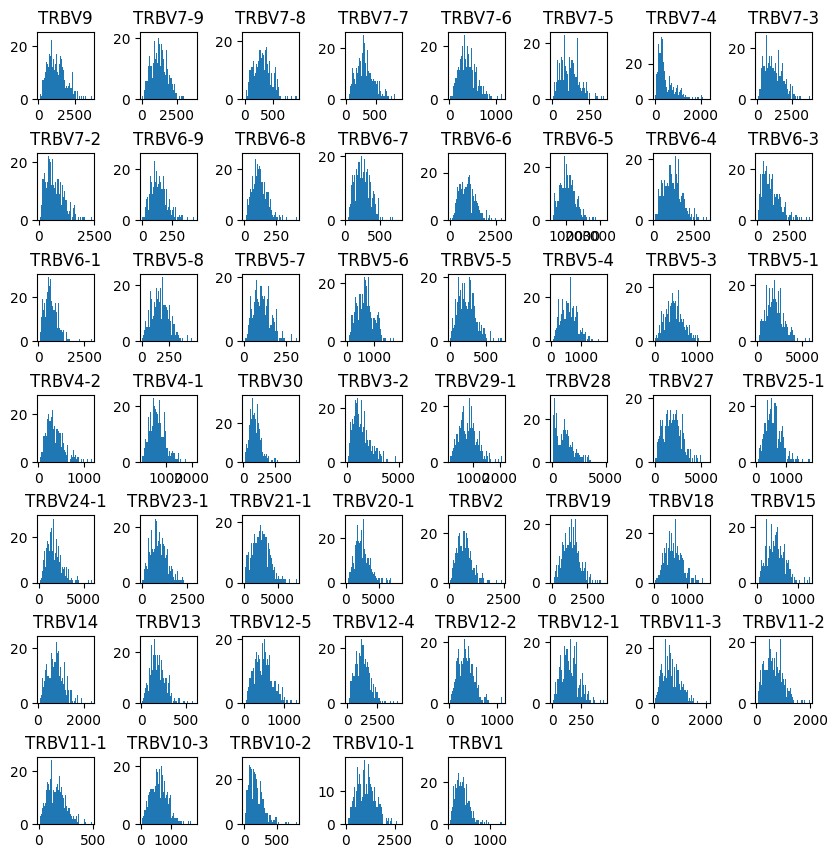

In [15]:
#check out rare clonotypes
plt.figure(figsize=(10,15))

for i, column in enumerate(df_v_clean.drop(['id'], axis=1).columns):
    plt.subplot(10, 8, i+1)
    plt.hist(x=df_v_clean[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

In [25]:
hip_batch = df_v_clean[df_v_clean['id'].str.startswith('HIP')].drop(["id"], axis=1)
batches = {'HIP': hip_batch}
batches

{'HIP':      TRBV9  TRBV7-9  TRBV7-8  TRBV7-7  TRBV7-6  TRBV7-5  TRBV7-4  TRBV7-3  \
 0     1810     2048      890      459      590      181     1110     1514   
 1     2404     2079      533      429      514      185      294     2250   
 2     2034     1749      453      442      583      166      399     1938   
 3      599      751      160      220      223       59      417      479   
 4      433      364       93      105      116       35       79      422   
 ..     ...      ...      ...      ...      ...      ...      ...      ...   
 656   1504     1917      475      480      565      230     1159     1727   
 657   1127     1221      317      252      269      126      260     1298   
 658    896     1033      237      242      323       78      190     1051   
 659   1109     1729      380      357      375      123      716      945   
 660   1277     1297      301      292      323      106      277     1433   
 
      TRBV7-2  TRBV6-9  ...  TRBV12-4  TRBV12-2  TRBV12

In [26]:
table = df_v_clean.drop(["id"], axis=1)
table = table.fillna(0)
table = table.astype(int)
table

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-9,...,TRBV12-4,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1
0,1810,2048,890,459,590,181,1110,1514,790,186,...,2092,568,274,778,778,191,1042,264,1570,560
1,2404,2079,533,429,514,185,294,2250,1036,172,...,2158,552,272,806,1253,248,1196,390,1870,713
2,2034,1749,453,442,583,166,399,1938,900,176,...,2070,488,239,1061,921,211,862,342,1370,509
3,599,751,160,220,223,59,417,479,414,119,...,794,234,98,253,264,63,376,117,540,190
4,433,364,93,105,116,35,79,422,202,38,...,387,119,45,203,220,61,195,44,314,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,1504,1917,475,480,565,230,1159,1727,1223,189,...,1691,726,309,1133,1405,272,1252,524,1668,585
657,1127,1221,317,252,269,126,260,1298,643,102,...,1108,296,129,660,614,187,557,148,889,247
658,896,1033,237,242,323,78,190,1051,559,90,...,1046,250,107,442,434,143,444,56,750,172
659,1109,1729,380,357,375,123,716,945,866,90,...,1354,411,186,866,899,160,681,286,986,344


In [27]:
V_table = StandardizedSegmentUsageTable(segment_usage_matrix=table, metadata=metadata, gene = 'TRB', segment_type = 'V',
                 standardization_method = 'log_exp')
V_table

     TRBV9  TRBV7-9  TRBV7-8  TRBV7-7  TRBV7-6  TRBV7-5  TRBV7-4  TRBV7-3  \
0     1810     2048      890      459      590      181     1110     1514   
1     2404     2079      533      429      514      185      294     2250   
2     2034     1749      453      442      583      166      399     1938   
3      599      751      160      220      223       59      417      479   
4      433      364       93      105      116       35       79      422   
..     ...      ...      ...      ...      ...      ...      ...      ...   
656   1504     1917      475      480      565      230     1159     1727   
657   1127     1221      317      252      269      126      260     1298   
658    896     1033      237      242      323       78      190     1051   
659   1109     1729      380      357      375      123      716      945   
660   1277     1297      301      292      323      106      277     1433   

     TRBV7-2  TRBV6-9  ...  TRBV12-4  TRBV12-2  TRBV12-1  TRBV11-3  TRBV11-

In [28]:
v_standart = V_table.preprocess_usage_table(group_mapping=batches, standardization_method='log_exp')
v_standart["id"]=df_v_clean["id"]
v_standart

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-9,...,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.024299,0.036533,0.013029,0.005766,0.008685,0.002964,0.015916,0.023676,0.008565,0.002707,...,0.009616,0.004848,0.006265,0.006840,0.001830,0.020487,0.004308,0.023888,0.009156,HIP14174.txt
1,0.041312,0.029487,0.007580,0.002610,0.002647,0.002630,0.004185,0.033841,0.013067,0.002013,...,0.006518,0.004118,0.004993,0.021182,0.003209,0.023123,0.005651,0.033033,0.011196,HIP13142.txt
2,0.043718,0.031079,0.008067,0.007293,0.011585,0.003079,0.008019,0.036104,0.014636,0.002952,...,0.008234,0.004658,0.021347,0.016951,0.003482,0.013604,0.006071,0.019159,0.009372,HIP02928.txt
3,0.012954,0.033115,0.005833,0.011255,0.008422,0.002228,0.016003,0.017808,0.017127,0.004813,...,0.011581,0.004419,0.003127,0.004058,0.001026,0.016678,0.005072,0.012836,0.007403,HIP14096.txt
4,0.044188,0.029527,0.007687,0.010250,0.009554,0.003063,0.007433,0.036980,0.016390,0.003044,...,0.011932,0.003728,0.017381,0.021709,0.006093,0.018911,0.003718,0.028656,0.007361,HIP01765.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,0.006151,0.021812,0.006347,0.004694,0.004587,0.003771,0.016202,0.025878,0.018323,0.002460,...,0.013433,0.005216,0.016597,0.025379,0.004141,0.025803,0.006994,0.020332,0.008672,HIP13951.txt
657,0.036596,0.044306,0.009855,0.005841,0.003435,0.004112,0.008696,0.039186,0.019617,0.002768,...,0.008389,0.003763,0.022420,0.020895,0.006477,0.018991,0.004524,0.027765,0.005888,HIP14039.txt
658,0.034840,0.047365,0.008903,0.010170,0.014955,0.002878,0.007773,0.039205,0.021646,0.003151,...,0.009515,0.003954,0.014889,0.015400,0.006174,0.017745,0.001382,0.032218,0.003806,HIP13627.txt
659,0.013262,0.053051,0.009469,0.008635,0.005510,0.002975,0.016586,0.021034,0.021984,0.001386,...,0.010855,0.004892,0.024228,0.026268,0.003386,0.015298,0.006705,0.011590,0.007435,HIP17698.txt


In [29]:
v_standart.to_csv("../../../data/cohort_II/nonfunctional_corrected/nf_trbv_hip_standart.csv")

In [31]:
norm1 = NormalizedSegmentUsageTable(segment_usage_matrix=df_v_clean.drop(['id'], axis=1), metadata=metadata)
table = norm1.preprocess_usage_table(df_v_clean.drop(['id'], axis=1))
table

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-9,...,TRBV12-4,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1
0,0.028406,0.032141,0.013968,0.007204,0.009259,0.002841,0.017420,0.023761,0.012398,0.002919,...,0.032832,0.008914,0.004300,0.012210,0.012210,0.002998,0.016353,0.004143,0.024639,0.008789
1,0.034543,0.029873,0.007659,0.006164,0.007386,0.002658,0.004224,0.032330,0.014886,0.002471,...,0.031008,0.007932,0.003908,0.011581,0.018004,0.003563,0.017185,0.005604,0.026870,0.010245
2,0.034879,0.029992,0.007768,0.007579,0.009997,0.002847,0.006842,0.033233,0.015433,0.003018,...,0.035496,0.008368,0.004098,0.018194,0.015793,0.003618,0.014782,0.005865,0.023493,0.008728
3,0.024593,0.030833,0.006569,0.009032,0.009155,0.002422,0.017120,0.019666,0.016997,0.004886,...,0.032598,0.009607,0.004023,0.010387,0.010839,0.002587,0.015437,0.004804,0.022170,0.007801
4,0.035155,0.029553,0.007551,0.008525,0.009418,0.002842,0.006414,0.034262,0.016400,0.003085,...,0.031420,0.009661,0.003653,0.016481,0.017861,0.004953,0.015832,0.003572,0.025493,0.007713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,0.021366,0.027234,0.006748,0.006819,0.008027,0.003267,0.016465,0.024534,0.017374,0.002685,...,0.024023,0.010314,0.004390,0.016096,0.019960,0.003864,0.017786,0.007444,0.023696,0.008311
657,0.032083,0.034759,0.009024,0.007174,0.007658,0.003587,0.007402,0.036951,0.018304,0.002904,...,0.031542,0.008426,0.003672,0.018788,0.017479,0.005323,0.015856,0.004213,0.025307,0.007031
658,0.031457,0.036267,0.008321,0.008496,0.011340,0.002738,0.006671,0.036899,0.019626,0.003160,...,0.036724,0.008777,0.003757,0.015518,0.015237,0.005021,0.015588,0.001966,0.026331,0.006039
659,0.024335,0.037939,0.008338,0.007834,0.008229,0.002699,0.015711,0.020736,0.019002,0.001975,...,0.029711,0.009018,0.004081,0.019002,0.019727,0.003511,0.014943,0.006276,0.021636,0.007548


In [33]:
df_v_norm = NormalizedSegmentUsageTable(segment_usage_matrix=df_v_clean.drop(['id'], axis=1), metadata=metadata).preprocess_usage_table(df_v_clean.drop(['id'], axis=1))
df_v_norm['id'] = df_v_clean['id']
df_v_norm

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-9,...,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.028406,0.032141,0.013968,0.007204,0.009259,0.002841,0.017420,0.023761,0.012398,0.002919,...,0.008914,0.004300,0.012210,0.012210,0.002998,0.016353,0.004143,0.024639,0.008789,HIP14174.txt
1,0.034543,0.029873,0.007659,0.006164,0.007386,0.002658,0.004224,0.032330,0.014886,0.002471,...,0.007932,0.003908,0.011581,0.018004,0.003563,0.017185,0.005604,0.026870,0.010245,HIP13142.txt
2,0.034879,0.029992,0.007768,0.007579,0.009997,0.002847,0.006842,0.033233,0.015433,0.003018,...,0.008368,0.004098,0.018194,0.015793,0.003618,0.014782,0.005865,0.023493,0.008728,HIP02928.txt
3,0.024593,0.030833,0.006569,0.009032,0.009155,0.002422,0.017120,0.019666,0.016997,0.004886,...,0.009607,0.004023,0.010387,0.010839,0.002587,0.015437,0.004804,0.022170,0.007801,HIP14096.txt
4,0.035155,0.029553,0.007551,0.008525,0.009418,0.002842,0.006414,0.034262,0.016400,0.003085,...,0.009661,0.003653,0.016481,0.017861,0.004953,0.015832,0.003572,0.025493,0.007713,HIP01765.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,0.021366,0.027234,0.006748,0.006819,0.008027,0.003267,0.016465,0.024534,0.017374,0.002685,...,0.010314,0.004390,0.016096,0.019960,0.003864,0.017786,0.007444,0.023696,0.008311,HIP13951.txt
657,0.032083,0.034759,0.009024,0.007174,0.007658,0.003587,0.007402,0.036951,0.018304,0.002904,...,0.008426,0.003672,0.018788,0.017479,0.005323,0.015856,0.004213,0.025307,0.007031,HIP14039.txt
658,0.031457,0.036267,0.008321,0.008496,0.011340,0.002738,0.006671,0.036899,0.019626,0.003160,...,0.008777,0.003757,0.015518,0.015237,0.005021,0.015588,0.001966,0.026331,0.006039,HIP13627.txt
659,0.024335,0.037939,0.008338,0.007834,0.008229,0.002699,0.015711,0.020736,0.019002,0.001975,...,0.009018,0.004081,0.019002,0.019727,0.003511,0.014943,0.006276,0.021636,0.007548,HIP17698.txt


In [35]:
df_v_norm.to_csv('../../../data/cohort_II/nonfunctional_corrected/nf_trbv_hip_norm.csv')

### Onlyfunctional sequences

In [37]:
metadata_path = '../../../data/cohort_II/metadata/metadata.txt'
data_path = '../../../data/cohort_II/onlyfunctional/'

In [38]:
t0 = time.time()

df_v = pd.DataFrame()

for file_name in tqdm(os.listdir(data_path)):
    if file_name.endswith(".txt"):
        with open(os.path.join(data_path, file_name), 'r') as file:
            total_counts = 0
            clonotype_v_dict = {}
            clonotype_d_dict = {}
            clonotype_j_dict = {}

            header = file.readline()        
            for line in file.readlines():
                data = line.strip().split('\t')
                total_counts += int(data[0])
                for clonotype in data[4:7]:
                    clonotype = clonotype.split(',')[0]
                    if 'V' in clonotype:
                        if clonotype in clonotype_v_dict.keys():
                            clonotype_v_dict[clonotype] += 1
                        else:
                            clonotype_v_dict[clonotype] = np.array([1])

            clonotype_v_dict['id'] = file_name


            if total_counts >= 10000:
                df_v = pd.concat([df_v, pd.DataFrame(clonotype_v_dict)]).sort_index(axis=1, ascending=False)
                
print((time.time() - t0)/60)

100%|██████████| 666/666 [08:04<00:00,  1.37it/s]

8.078083483378093


In [40]:
df_v

,id,TRBV9,TRBV8-2,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,...,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,TRAV3,TRAV20
0,HIP14174.txt,10231,1.0,10786,8034,1036,3066,41.0,252,2472,...,84.0,1258,4578,807.0,4947,1634,1352,212,NaN,NaN
0,HIP13142.txt,10696,NaN,15621,4462,952,2935,62.0,37,5143,...,98.0,1255,6792,951.0,5272,2005,2554,286,NaN,NaN
0,HIP02928.txt,11635,NaN,11509,3793,837,3023,64.0,73,3605,...,66.0,1616,6037,1124.0,3084,1621,1733,191,NaN,NaN
0,HIP14096.txt,3273,NaN,5526,1629,367,1122,22.0,77,609,...,33.0,367,1660,247.0,2235,867,826,77,NaN,NaN
0,HIP01765.txt,2023,1.0,2314,810,167,548,10.0,13,727,...,16.0,258,1090,274.0,976,275,218,29,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HIP13951.txt,8531,NaN,12250,4003,979,3026,72.0,321,3076,...,94.0,1839,8320,1085.0,6165,2536,2669,234,NaN,NaN
0,HIP14039.txt,6183,NaN,6897,2350,651,1811,36.0,41,4013,...,46.0,1485,3385,813.0,2906,590,824,95,1.0,NaN
0,HIP13627.txt,6850,NaN,8119,2516,550,1864,24.0,28,3302,...,45.0,855,2916,743.0,3195,399,256,62,NaN,NaN
0,HIP17698.txt,5889,1.0,11239,1578,386,1754,32.0,228,1791,...,72.0,1285,5722,785.0,3598,1292,1561,120,NaN,NaN


In [41]:
df_v.to_csv("../../../data/cohort_II/onlyfunctional_corrected/of_v_unnorm.csv")

In [43]:
df_v = pd.read_csv("../../../data/cohort_II/onlyfunctional_corrected/of_v_unnorm.csv").drop('Unnamed: 0', axis=1)
df_v.head()

,id,TRBV9,TRBV8-2,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,...,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,TRAV3,TRAV20
0,HIP14174.txt,10231,1.0,10786,8034,1036,3066,41.0,252,2472,...,84.0,1258,4578,807.0,4947,1634,1352,212,NaN,NaN
1,HIP13142.txt,10696,NaN,15621,4462,952,2935,62.0,37,5143,...,98.0,1255,6792,951.0,5272,2005,2554,286,NaN,NaN
2,HIP02928.txt,11635,NaN,11509,3793,837,3023,64.0,73,3605,...,66.0,1616,6037,1124.0,3084,1621,1733,191,NaN,NaN
3,HIP14096.txt,3273,NaN,5526,1629,367,1122,22.0,77,609,...,33.0,367,1660,247.0,2235,867,826,77,NaN,NaN
4,HIP01765.txt,2023,1.0,2314,810,167,548,10.0,13,727,...,16.0,258,1090,274.0,976,275,218,29,NaN,NaN


In [44]:
df_v_clean = df_v.loc[:,~df_v.columns.str.startswith('TRA')]
df_v_clean = df_v_clean.drop(columns=df_v_clean.select_dtypes(include='float').columns)

df_v_clean

,id,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,...,TRBV14,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1
0,HIP14174.txt,10231,10786,8034,1036,3066,252,2472,7943,7097,...,2622,1978,1601,13498,1258,4578,4947,1634,1352,212
1,HIP13142.txt,10696,15621,4462,952,2935,37,5143,8418,6897,...,2186,1951,1592,13705,1255,6792,5272,2005,2554,286
2,HIP02928.txt,11635,11509,3793,837,3023,73,3605,7192,7155,...,2318,3072,1578,13871,1616,6037,3084,1621,1733,191
3,HIP14096.txt,3273,5526,1629,367,1122,77,609,4886,3517,...,969,650,546,6353,367,1660,2235,867,826,77
4,HIP01765.txt,2023,2314,810,167,548,13,727,1765,1369,...,439,329,95,2458,258,1090,976,275,218,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,HIP13951.txt,8531,12250,4003,979,3026,321,3076,9153,6361,...,2926,2773,866,11836,1839,8320,6165,2536,2669,234
661,HIP14039.txt,6183,6897,2350,651,1811,41,4013,4585,3395,...,1690,1089,1017,6358,1485,3385,2906,590,824,95
662,HIP13627.txt,6850,8119,2516,550,1864,28,3302,7074,4323,...,1319,1013,355,8420,855,2916,3195,399,256,62
663,HIP17698.txt,5889,11239,1578,386,1754,228,1791,7854,3998,...,1371,1305,311,8478,1285,5722,3598,1292,1561,120


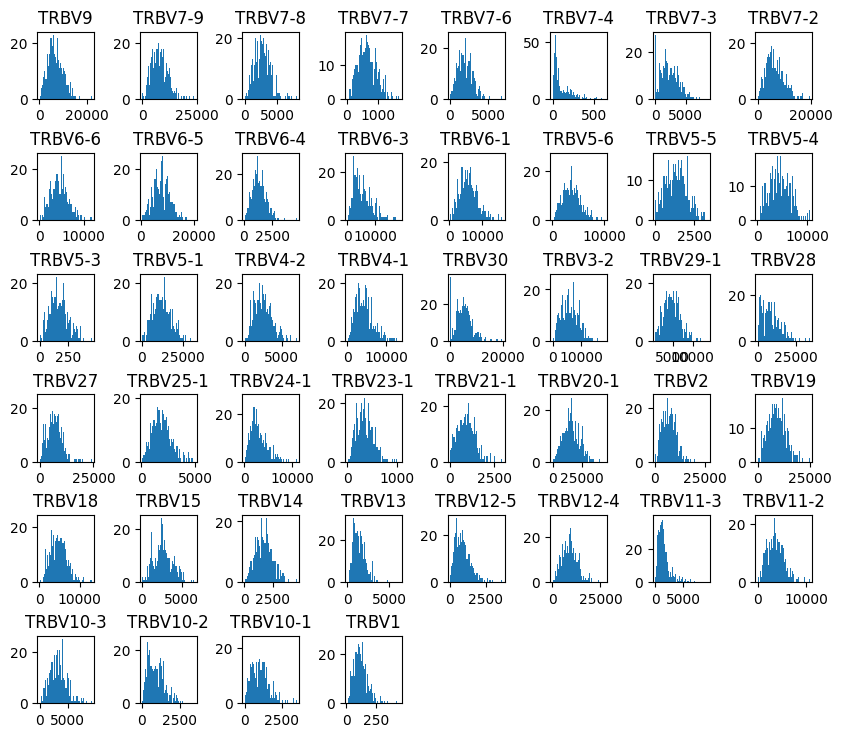

In [45]:
#check out rare clonotypes
plt.figure(figsize=(10,15))

for i, column in enumerate(df_v_clean.drop(['id'], axis=1).columns):
    plt.subplot(10, 8, i+1)
    plt.hist(x=df_v_clean[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

In [ ]:
metadata['id'].nunique()

666

In [ ]:
df_v_clean['id'].nunique()

665

In [49]:
hip_batch = df_v_clean[df_v_clean['id'].str.startswith('HIP')].drop(["id"], axis=1)
batches = {'HIP': hip_batch}
batches

{'HIP':      TRBV9  TRBV7-9  TRBV7-8  TRBV7-7  TRBV7-6  TRBV7-4  TRBV7-3  TRBV7-2  \
 0    10231    10786     8034     1036     3066      252     2472     7943   
 1    10696    15621     4462      952     2935       37     5143     8418   
 2    11635    11509     3793      837     3023       73     3605     7192   
 3     3273     5526     1629      367     1122       77      609     4886   
 4     2023     2314      810      167      548       13      727     1765   
 ..     ...      ...      ...      ...      ...      ...      ...      ...   
 660   8531    12250     4003      979     3026      321     3076     9153   
 661   6183     6897     2350      651     1811       41     4013     4585   
 662   6850     8119     2516      550     1864       28     3302     7074   
 663   5889    11239     1578      386     1754      228     1791     7854   
 664   5927     7361     2389      612     1556       30     2927     8683   
 
      TRBV6-6  TRBV6-5  ...  TRBV14  TRBV13  TRBV12-5  

In [50]:
table = df_v_clean.drop(["id"], axis=1)
table = table.fillna(0)
table = table.astype(int)
table

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,TRBV6-5,...,TRBV14,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1
0,10231,10786,8034,1036,3066,252,2472,7943,7097,11467,...,2622,1978,1601,13498,1258,4578,4947,1634,1352,212
1,10696,15621,4462,952,2935,37,5143,8418,6897,9890,...,2186,1951,1592,13705,1255,6792,5272,2005,2554,286
2,11635,11509,3793,837,3023,73,3605,7192,7155,12084,...,2318,3072,1578,13871,1616,6037,3084,1621,1733,191
3,3273,5526,1629,367,1122,77,609,4886,3517,6195,...,969,650,546,6353,367,1660,2235,867,826,77
4,2023,2314,810,167,548,13,727,1765,1369,2091,...,439,329,95,2458,258,1090,976,275,218,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,8531,12250,4003,979,3026,321,3076,9153,6361,11097,...,2926,2773,866,11836,1839,8320,6165,2536,2669,234
661,6183,6897,2350,651,1811,41,4013,4585,3395,4671,...,1690,1089,1017,6358,1485,3385,2906,590,824,95
662,6850,8119,2516,550,1864,28,3302,7074,4323,5385,...,1319,1013,355,8420,855,2916,3195,399,256,62
663,5889,11239,1578,386,1754,228,1791,7854,3998,6590,...,1371,1305,311,8478,1285,5722,3598,1292,1561,120


In [51]:
V_table = StandardizedSegmentUsageTable(segment_usage_matrix=table, metadata=metadata, gene = 'TRB', segment_type = 'V',#metadata=pd.DataFrame
                 standardization_method = 'log_exp')
V_table

     TRBV9  TRBV7-9  TRBV7-8  TRBV7-7  TRBV7-6  TRBV7-4  TRBV7-3  TRBV7-2  \
0    10231    10786     8034     1036     3066      252     2472     7943   
1    10696    15621     4462      952     2935       37     5143     8418   
2    11635    11509     3793      837     3023       73     3605     7192   
3     3273     5526     1629      367     1122       77      609     4886   
4     2023     2314      810      167      548       13      727     1765   
..     ...      ...      ...      ...      ...      ...      ...      ...   
660   8531    12250     4003      979     3026      321     3076     9153   
661   6183     6897     2350      651     1811       41     4013     4585   
662   6850     8119     2516      550     1864       28     3302     7074   
663   5889    11239     1578      386     1754      228     1791     7854   
664   5927     7361     2389      612     1556       30     2927     8683   

     TRBV6-6  TRBV6-5  ...  TRBV14  TRBV13  TRBV12-5  TRBV12-4  TRBV11-3  \

In [52]:
v_standart = V_table.preprocess_usage_table(group_mapping=batches, standardization_method='log_exp')
v_standart["id"]=df_v_clean["id"]
v_standart

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,TRBV6-5,...,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.036848,0.027152,0.024423,0.003873,0.011357,0.000787,0.011540,0.026488,0.029365,0.038972,...,0.006809,0.006071,0.051211,0.004340,0.012375,0.018543,0.006121,0.005191,0.000817,HIP14174.txt
1,0.031337,0.064403,0.015025,0.002168,0.006614,0.000205,0.016803,0.025187,0.016115,0.014166,...,0.005128,0.005809,0.039112,0.003803,0.025111,0.017162,0.006996,0.008357,0.001020,HIP13142.txt
2,0.055871,0.049736,0.015282,0.002831,0.013958,0.000434,0.014913,0.026592,0.037503,0.055353,...,0.013050,0.006514,0.066679,0.007024,0.027690,0.005665,0.006626,0.007095,0.000818,HIP02928.txt
3,0.011487,0.047518,0.013123,0.001925,0.005572,0.000713,0.008096,0.043198,0.038716,0.061171,...,0.002949,0.004890,0.060177,0.002217,0.006312,0.019755,0.007287,0.007203,0.000643,HIP14096.txt
4,0.036874,0.037482,0.015042,0.002047,0.008047,0.000376,0.014671,0.032374,0.026807,0.029607,...,0.004340,0.000951,0.039925,0.004656,0.020080,0.018560,0.005368,0.004149,0.000457,HIP01765.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0.012686,0.027501,0.012581,0.002298,0.007147,0.000874,0.012989,0.028567,0.009035,0.022544,...,0.010428,0.002457,0.020346,0.006549,0.032455,0.023261,0.008032,0.008499,0.000839,HIP13951.txt
661,0.050718,0.055981,0.016889,0.005448,0.015252,0.000431,0.019180,0.031764,0.021513,0.015220,...,0.007763,0.007088,0.038248,0.011064,0.027088,0.023467,0.004185,0.006177,0.000686,HIP14039.txt
662,0.049096,0.061150,0.015904,0.002945,0.012482,0.000283,0.017457,0.046404,0.032551,0.016488,...,0.004834,0.001528,0.059354,0.005457,0.015587,0.022478,0.001785,0.000857,0.000196,HIP13627.txt
663,0.021853,0.080111,0.005538,0.000325,0.005969,0.000915,0.012728,0.045979,0.011699,0.020950,...,0.006490,0.000873,0.040689,0.007832,0.035972,0.021871,0.007268,0.008362,0.000666,HIP17698.txt


In [53]:
v_standart.to_csv("../../../data/cohort_II/onlyfunctional_corrected/of_trbv_hip_standart.csv")

In [54]:
norm1 = NormalizedSegmentUsageTable(segment_usage_matrix=df_v_clean.drop(['id'], axis=1), metadata=metadata)
table = norm1.preprocess_usage_table(df_v_clean.drop(['id'], axis=1))
table

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,TRBV6-5,...,TRBV14,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1
0,0.037347,0.039373,0.029327,0.003782,0.011192,0.000920,0.009024,0.028995,0.025907,0.041859,...,0.009571,0.007220,0.005844,0.049273,0.004592,0.016711,0.018058,0.005965,0.004935,0.000774
1,0.034356,0.050176,0.014332,0.003058,0.009427,0.000119,0.016520,0.027039,0.022154,0.031767,...,0.007022,0.006267,0.005114,0.044021,0.004031,0.021816,0.016934,0.006440,0.008204,0.000919
2,0.046723,0.046217,0.015232,0.003361,0.012140,0.000293,0.014477,0.028881,0.028733,0.048526,...,0.009309,0.012336,0.006337,0.055703,0.006489,0.024243,0.012385,0.006510,0.006959,0.000767
3,0.026591,0.044894,0.013234,0.002982,0.009115,0.000626,0.004948,0.039695,0.028573,0.050329,...,0.007872,0.005281,0.004436,0.051613,0.002982,0.013486,0.018158,0.007044,0.006711,0.000626
4,0.036844,0.042144,0.014752,0.003042,0.009981,0.000237,0.013241,0.032145,0.024933,0.038083,...,0.007995,0.005992,0.001730,0.044767,0.004699,0.019852,0.017776,0.005008,0.003970,0.000528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0.027066,0.038864,0.012700,0.003106,0.009600,0.001018,0.009759,0.029039,0.020181,0.035206,...,0.009283,0.008798,0.002747,0.037551,0.005834,0.026396,0.019559,0.008046,0.008468,0.000742
661,0.043139,0.048120,0.016396,0.004542,0.012635,0.000286,0.027999,0.031989,0.023687,0.032589,...,0.011791,0.007598,0.007096,0.044359,0.010361,0.023617,0.020275,0.004116,0.005749,0.000663
662,0.042107,0.049908,0.015466,0.003381,0.011458,0.000172,0.020298,0.043484,0.026574,0.033102,...,0.008108,0.006227,0.002182,0.051758,0.005256,0.017925,0.019640,0.002453,0.001574,0.000381
663,0.030919,0.059008,0.008285,0.002027,0.009209,0.001197,0.009403,0.041235,0.020991,0.034599,...,0.007198,0.006852,0.001633,0.044512,0.006747,0.030042,0.018890,0.006783,0.008196,0.000630


In [55]:
df_v_norm = NormalizedSegmentUsageTable(segment_usage_matrix=df_v_clean.drop(['id'], axis=1), metadata=metadata).preprocess_usage_table(df_v_clean.drop(['id'], axis=1))
df_v_norm['id'] = df_v_clean['id']
df_v_norm

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,TRBV6-5,...,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.037347,0.039373,0.029327,0.003782,0.011192,0.000920,0.009024,0.028995,0.025907,0.041859,...,0.007220,0.005844,0.049273,0.004592,0.016711,0.018058,0.005965,0.004935,0.000774,HIP14174.txt
1,0.034356,0.050176,0.014332,0.003058,0.009427,0.000119,0.016520,0.027039,0.022154,0.031767,...,0.006267,0.005114,0.044021,0.004031,0.021816,0.016934,0.006440,0.008204,0.000919,HIP13142.txt
2,0.046723,0.046217,0.015232,0.003361,0.012140,0.000293,0.014477,0.028881,0.028733,0.048526,...,0.012336,0.006337,0.055703,0.006489,0.024243,0.012385,0.006510,0.006959,0.000767,HIP02928.txt
3,0.026591,0.044894,0.013234,0.002982,0.009115,0.000626,0.004948,0.039695,0.028573,0.050329,...,0.005281,0.004436,0.051613,0.002982,0.013486,0.018158,0.007044,0.006711,0.000626,HIP14096.txt
4,0.036844,0.042144,0.014752,0.003042,0.009981,0.000237,0.013241,0.032145,0.024933,0.038083,...,0.005992,0.001730,0.044767,0.004699,0.019852,0.017776,0.005008,0.003970,0.000528,HIP01765.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0.027066,0.038864,0.012700,0.003106,0.009600,0.001018,0.009759,0.029039,0.020181,0.035206,...,0.008798,0.002747,0.037551,0.005834,0.026396,0.019559,0.008046,0.008468,0.000742,HIP13951.txt
661,0.043139,0.048120,0.016396,0.004542,0.012635,0.000286,0.027999,0.031989,0.023687,0.032589,...,0.007598,0.007096,0.044359,0.010361,0.023617,0.020275,0.004116,0.005749,0.000663,HIP14039.txt
662,0.042107,0.049908,0.015466,0.003381,0.011458,0.000172,0.020298,0.043484,0.026574,0.033102,...,0.006227,0.002182,0.051758,0.005256,0.017925,0.019640,0.002453,0.001574,0.000381,HIP13627.txt
663,0.030919,0.059008,0.008285,0.002027,0.009209,0.001197,0.009403,0.041235,0.020991,0.034599,...,0.006852,0.001633,0.044512,0.006747,0.030042,0.018890,0.006783,0.008196,0.000630,HIP17698.txt


In [56]:
df_v_norm.to_csv('../../../data/cohort_II/onlyfunctional_corrected/of_trbv_hip_norm.csv')